<a href="https://colab.research.google.com/github/majidmostafavi/COVID-19/blob/master/Crona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [113]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

--2020-03-08 08:40:34--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32096 (31K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv.1’

time_series_19-covi 100%[===================>]  31.34K  --.-KB/s    in 0.008s  

2020-03-08 08:40:34 (3.76 MB/s) - ‘time_series_19-covid-Confirmed.csv.1’ saved [32096/32096]



In [114]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,102,119,120


In [115]:
def get_place(row):
    if row['Country/Region'] == 'Mainland China':
        return 'China'
    else: return 'World'
    
df['Long'] = df.apply(lambda row: get_place(row), axis=1)
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,China,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,China,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.0572,China,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,China,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,China,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,102,119,120


In [0]:
china =df[df.Long == 'China']

In [117]:
china.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,China,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,China,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414,414,418,418,422,426
2,Chongqing,Mainland China,30.0572,China,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,China,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,China,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91,102,119,120


In [0]:
world =df[df.Long != 'China']

In [119]:
world.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
31,NaN,Thailand,15.0000,World,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50
32,NaN,Japan,36.0000,World,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461
33,NaN,South Korea,36.0000,World,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041
34,Taiwan,Taiwan,23.7000,World,1,1,3,3,4,5,8,8,9,10,10,10,10,11,11,16,16,17,18,18,18,18,18,18,18,20,22,22,23,24,26,26,28,30,31,32,32,34,39,40,41,42,42,44,45,45
35,"King County, WA",US,47.6062,World,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,9,14,21,31,51,58,71


remove colum

In [120]:
daily_china = china.iloc[:, 4:]
daily_world = world.iloc[:, 4:]
daily_china.head()
daily_world.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
31,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50
32,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461
33,1,1,2,2,3,4,4,4,4,11,12,15,15,16,19,23,24,24,25,27,28,28,28,28,28,29,30,31,31,104,204,433,602,833,977,1261,1766,2337,3150,3736,4335,5186,5621,6088,6593,7041
34,1,1,3,3,4,5,8,8,9,10,10,10,10,11,11,16,16,17,18,18,18,18,18,18,18,20,22,22,23,24,26,26,28,30,31,32,32,34,39,40,41,42,42,44,45,45
35,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,6,9,14,21,31,51,58,71


remove null data

In [121]:
world.isnull().sum()

Province/State    94
Country/Region     0
Lat                0
Long               0
1/22/20            0
1/23/20            0
1/24/20            0
1/25/20            0
1/26/20            0
1/27/20            0
1/28/20            0
1/29/20            0
1/30/20            0
1/31/20            0
2/1/20             0
2/2/20             0
2/3/20             0
2/4/20             0
2/5/20             0
2/6/20             0
2/7/20             0
2/8/20             0
2/9/20             0
2/10/20            0
2/11/20            0
2/12/20            0
2/13/20            0
2/14/20            0
2/15/20            0
2/16/20            0
2/17/20            0
2/18/20            0
2/19/20            0
2/20/20            0
2/21/20            0
2/22/20            0
2/23/20            0
2/24/20            0
2/25/20            0
2/26/20            0
2/27/20            0
2/28/20            0
2/29/20            0
3/1/20             0
3/2/20             0
3/3/20             0
3/4/20             0
3/5/20       

In [122]:

daily_cases_china = daily_china.sum(axis=0)
daily_cases_world = daily_world.sum(axis=0)
daily_cases_world

1/22/20        8
1/23/20       14
1/24/20       25
1/25/20       35
1/26/20       56
1/27/20       64
1/28/20       84
1/29/20       96
1/30/20      110
1/31/20      144
2/1/20       167
2/2/20       180
2/3/20       188
2/4/20       212
2/5/20       227
2/6/20       265
2/7/20       317
2/8/20       343
2/9/20       361
2/10/20      457
2/11/20      476
2/12/20      523
2/13/20      538
2/14/20      595
2/15/20      685
2/16/20      780
2/17/20      896
2/18/20      999
2/19/20     1095
2/20/20     1200
2/21/20     1371
2/22/20     1677
2/23/20     2047
2/24/20     2418
2/25/20     2755
2/26/20     3332
2/27/20     4258
2/28/20     5298
2/29/20     6762
3/1/20      8545
3/2/20     10283
3/3/20     12692
3/4/20     14852
3/5/20     17463
3/6/20     21226
3/7/20     25184
dtype: int64

In [0]:
daily_cases_china.index = pd.to_datetime(daily_cases_china.index)
daily_cases_world.index = pd.to_datetime(daily_cases_world.index)

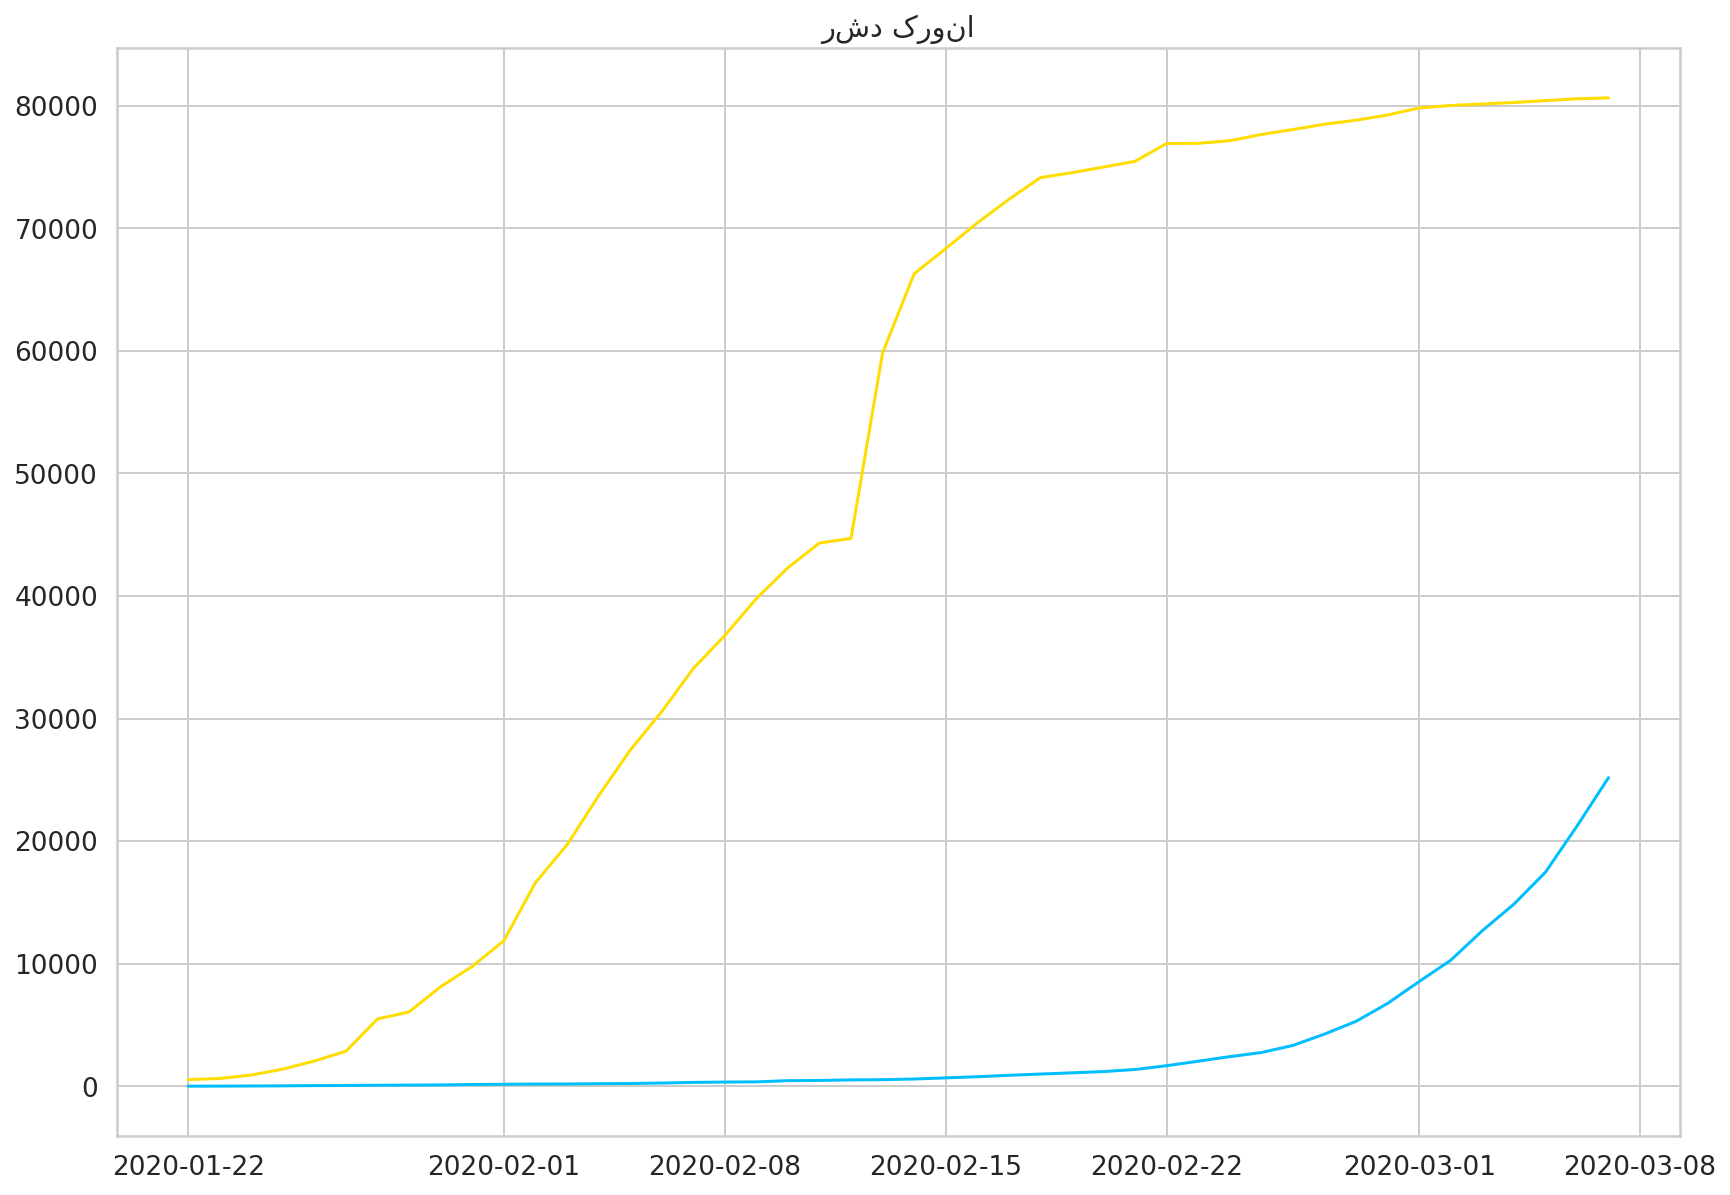

In [124]:
plt.plot(daily_cases_world,label="World")
plt.plot(daily_cases_china,label="China")

plt.title("رشد کرونا");

In [0]:
daily_cases_world = daily_cases_world.diff().fillna(daily_cases_world[0]).astype(np.int64)
daily_cases_china = daily_cases_china.diff().fillna(daily_cases_china[0]).astype(np.int64)

In [126]:
daily_cases_world.head()
daily_cases_china.head()

2020-01-22    547
2020-01-23     92
2020-01-24    277
2020-01-25    483
2020-01-26    663
dtype: int64

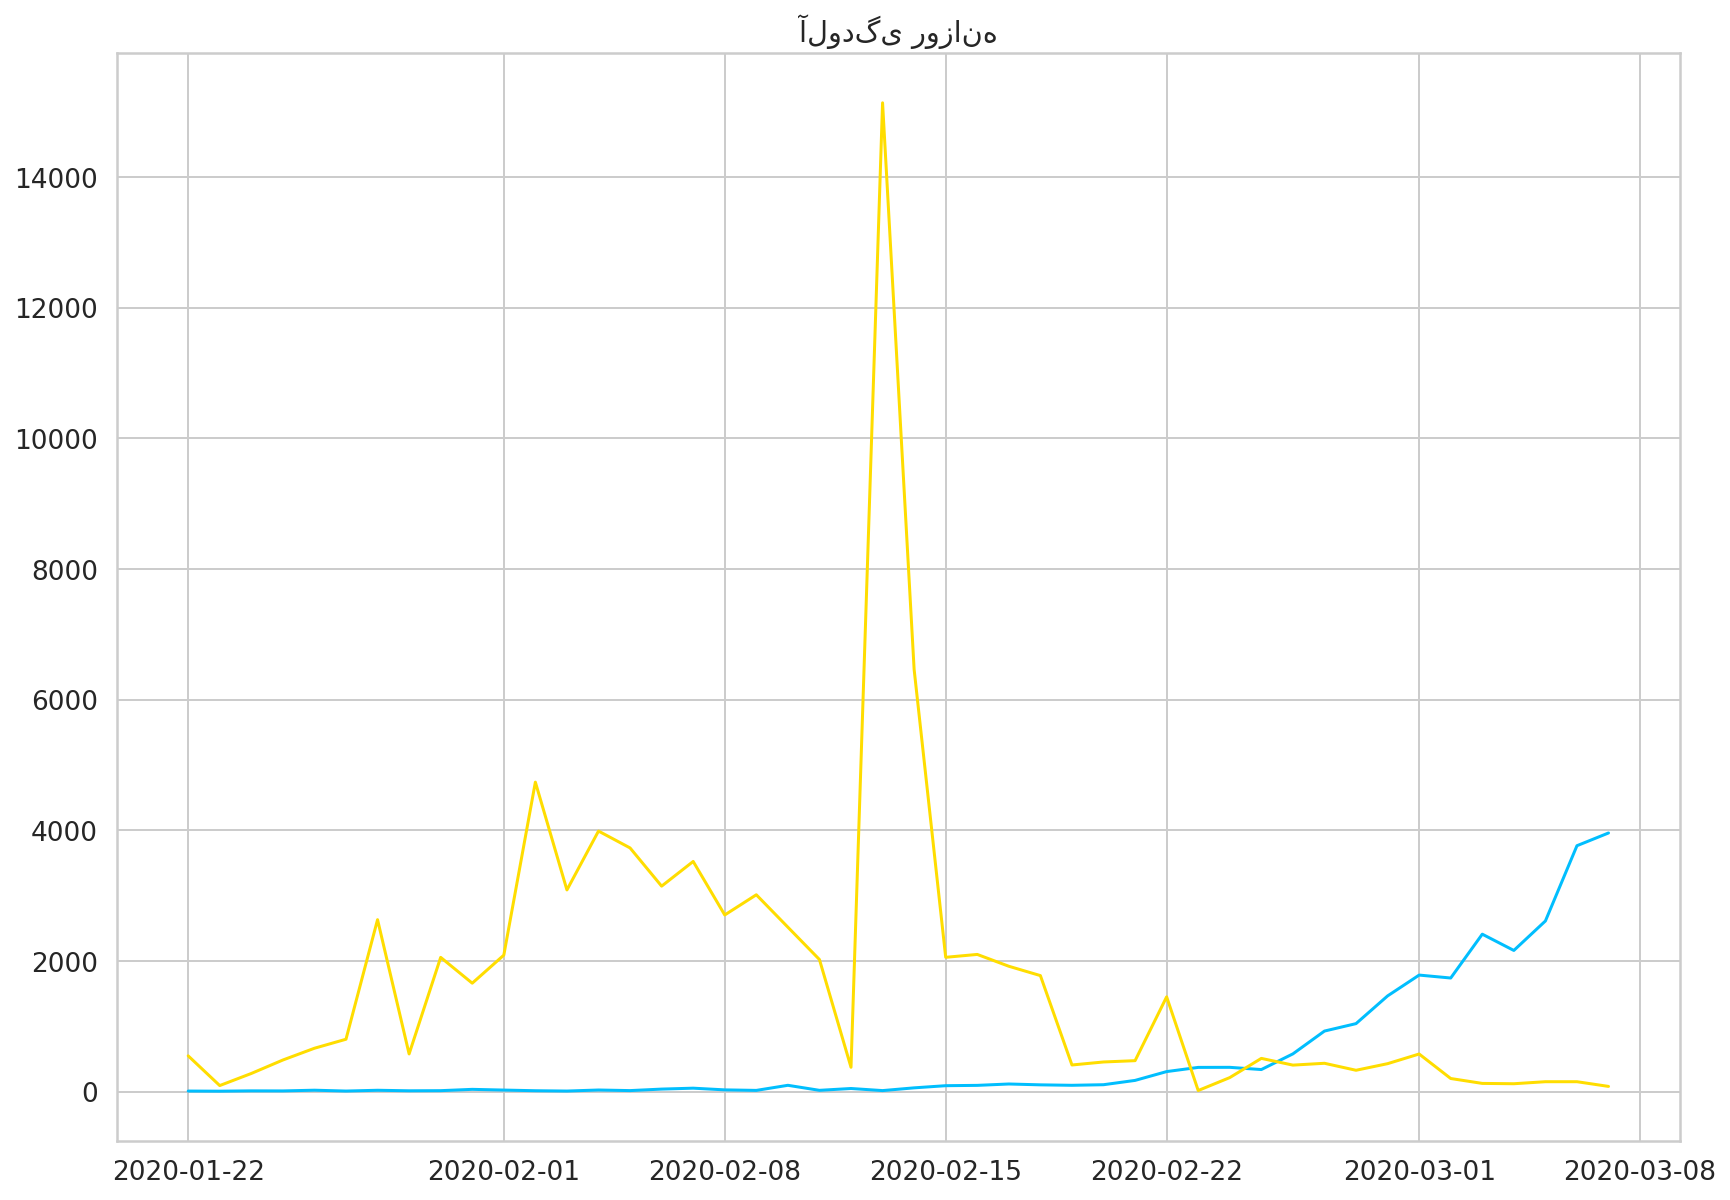

In [127]:
plt.plot(daily_cases_world, label= "World")
plt.plot(daily_cases_china, label= "China")
plt.title("آلودگی روزانه");

In [128]:
daily_cases_world.shape

(46,)

Preprocessing

In [0]:
test_data_size = 15

train_data = daily_cases_world[:-test_data_size]
test_data = daily_cases_world[-test_data_size:]

In [130]:
train_data.shape

(31,)

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [0]:
def sliding_windows(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)
seq_length = 5
X_train, y_train = sliding_windows(train_data, seq_length)
X_test, y_test = sliding_windows(test_data, seq_length)

In [0]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [134]:
X_train.shape

torch.Size([25, 5, 1])

In [135]:
X_train[:2]

tensor([[[0.0121],
         [0.0000],
         [0.0303],
         [0.0242],
         [0.0909]],

        [[0.0000],
         [0.0303],
         [0.0242],
         [0.0909],
         [0.0121]]])

In [136]:
y_train.shape

torch.Size([25, 1])

In [137]:
y_train[:2]

tensor([[0.0121],
        [0.0848]])

In [138]:
train_data[:10]

array([[0.01212121],
       [0.        ],
       [0.03030303],
       [0.02424242],
       [0.09090909],
       [0.01212121],
       [0.08484848],
       [0.03636364],
       [0.04848485],
       [0.16969697]])

Building Model

In [0]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, input_dim, hidden_dim, seq_len, num_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.num_layers = num_layers

    self.lstm = nn.LSTM(
      input_size=input_dim, 
      hidden_size=hidden_dim, 
      num_layers=num_layers, 
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=hidden_dim, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.num_layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.num_layers, self.seq_len, self.hidden_dim)
    )

  def forward(self, input):
    lstm_out, self.hidden = self.lstm(
      input.view(len(input), self.seq_len, -1),
      self.hidden
    )
    y_pred = self.linear(
      lstm_out.view(self.seq_len, len(input), self.hidden_dim)[-1]
    )
    return y_pred

Training

In [0]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [141]:
model = CoronaVirusPredictor(1, 512, seq_len=seq_length, num_layers=2)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)

Epoch 0 train loss: 2.460564613342285 test loss: 1527.0262451171875
Epoch 10 train loss: 1.1253514289855957 test loss: 1287.5694580078125
Epoch 20 train loss: 0.9270413517951965 test loss: 838.69580078125
Epoch 30 train loss: 0.7155012488365173 test loss: 366.08001708984375
Epoch 40 train loss: 0.6395223140716553 test loss: 258.75323486328125
Epoch 50 train loss: 0.631439208984375 test loss: 229.1367645263672


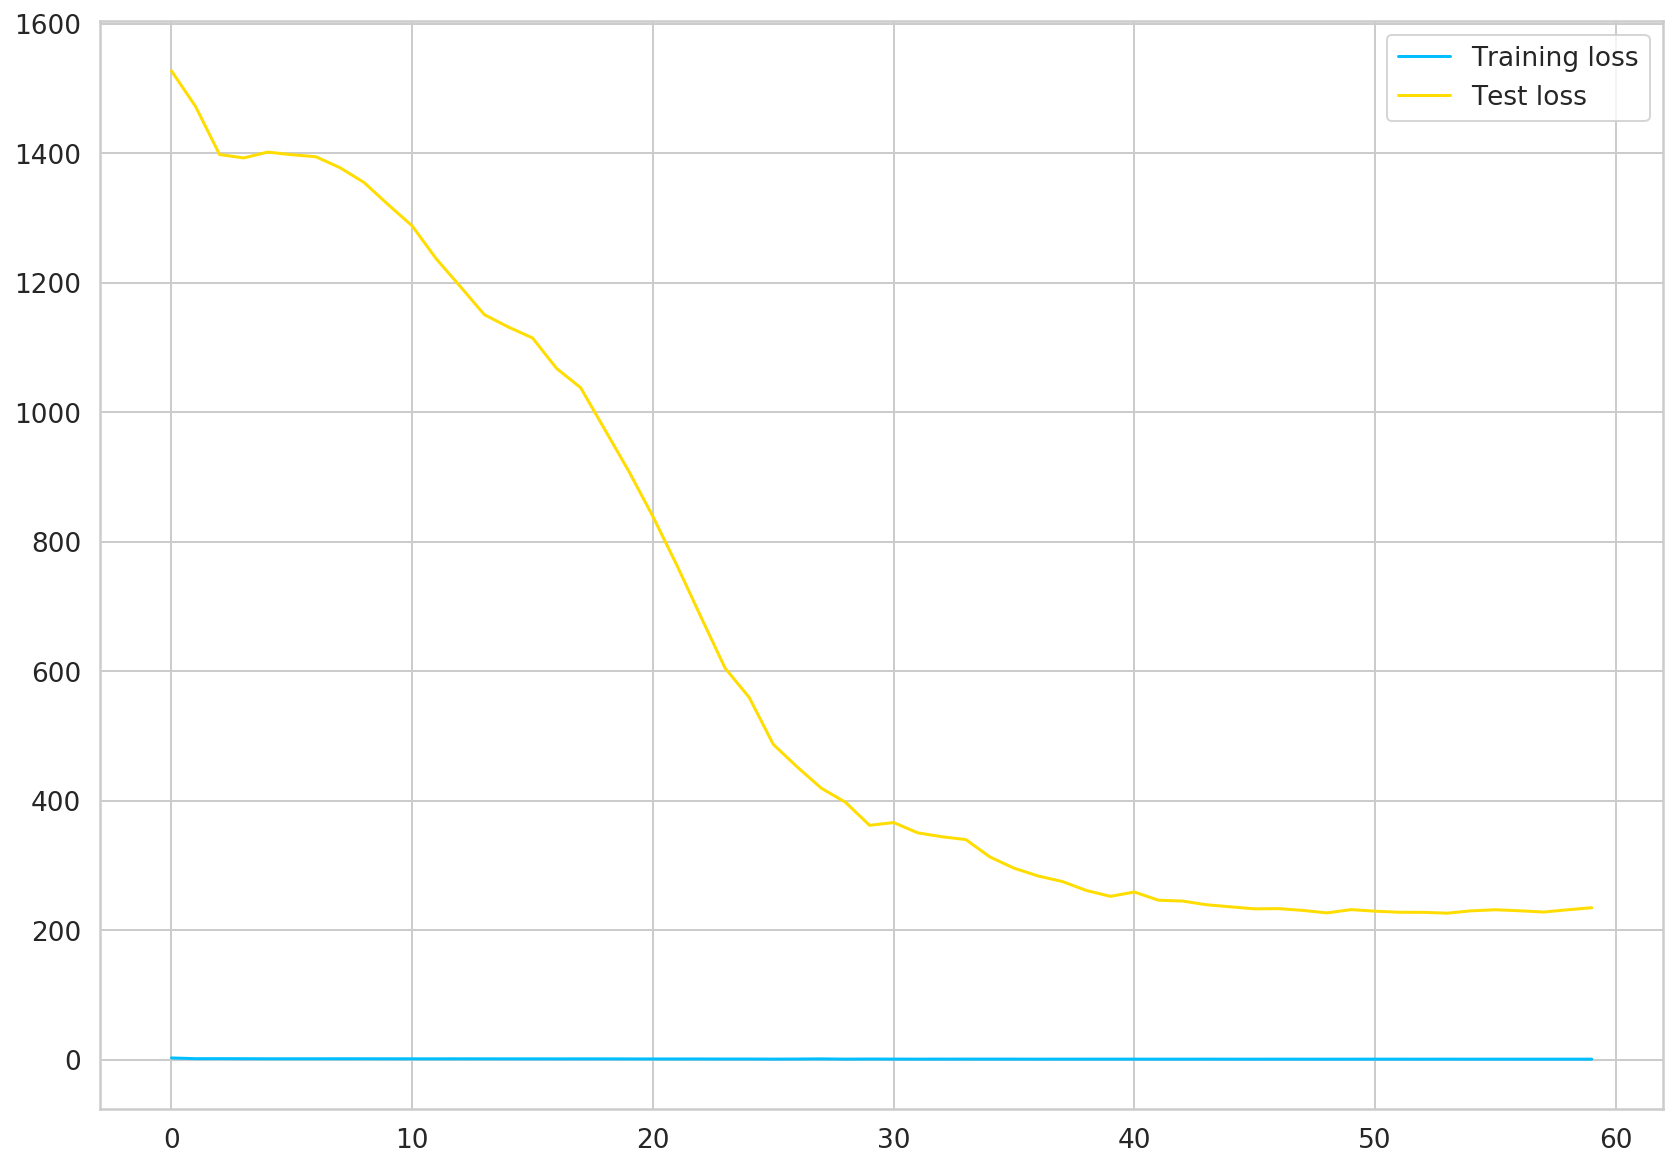

In [142]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

Predicting Daily Caces

In [0]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()    
    


In [0]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

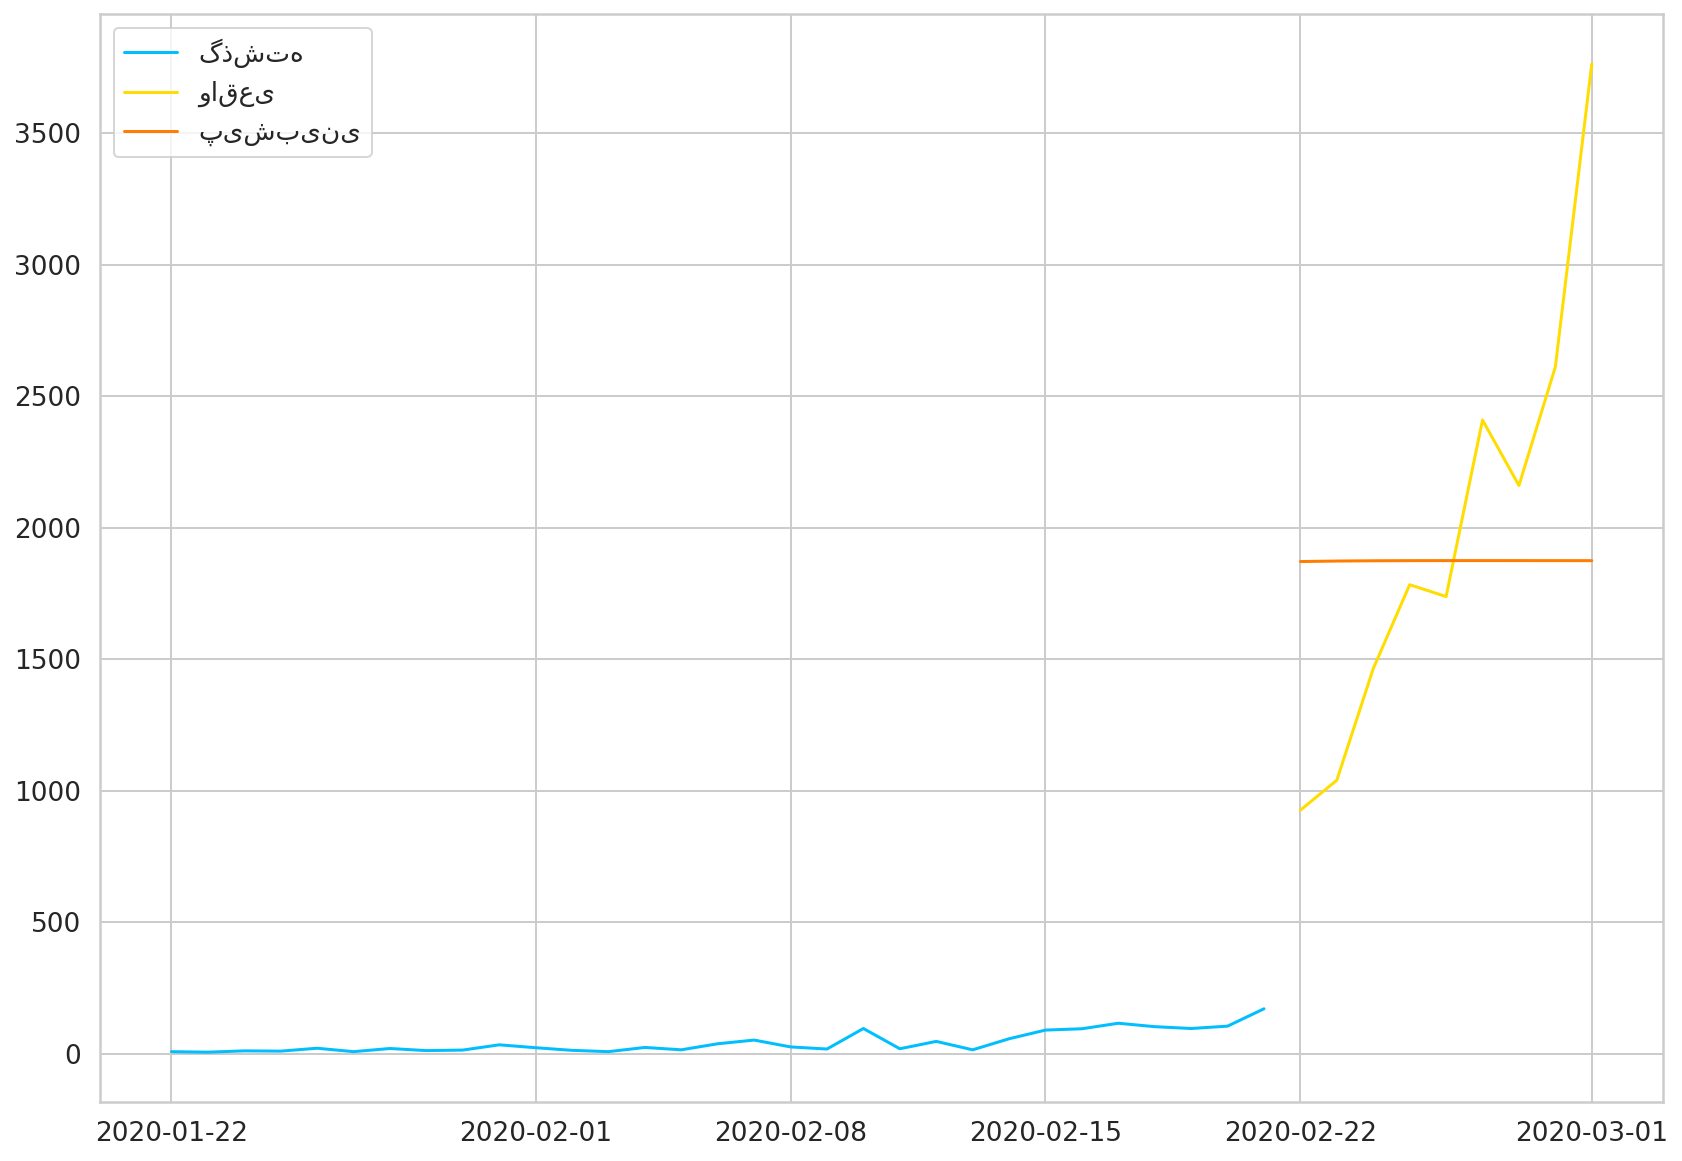

In [146]:
plt.plot(
  daily_cases_world.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='گذشته'
)

plt.plot(
  daily_cases_world.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='واقعی'
)

plt.plot(
  daily_cases_world.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='پیشبینی'
)

plt.legend();

In [0]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases_world, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases_world, axis=1))

In [148]:
all_data.shape

(46, 1)

In [0]:
X_all, y_all = sliding_windows(all_data, seq_length)

In [0]:
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [151]:
model = CoronaVirusPredictor(1, 512, seq_len=seq_length, num_layers=2)

model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 2.8866257667541504
Epoch 10 train loss: 1.1080904006958008
Epoch 20 train loss: 0.9970515370368958
Epoch 30 train loss: 0.7231297492980957
Epoch 40 train loss: 0.5949245691299438
Epoch 50 train loss: 0.6056777834892273


Predicting Future Cases

In [0]:
DAYS_TO_PREDICT = 15

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [0]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [154]:
daily_cases_world.index[-1]

Timestamp('2020-03-07 00:00:00')

In [0]:
predicted_index = pd.date_range(
  start=daily_cases_world.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

In [0]:
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

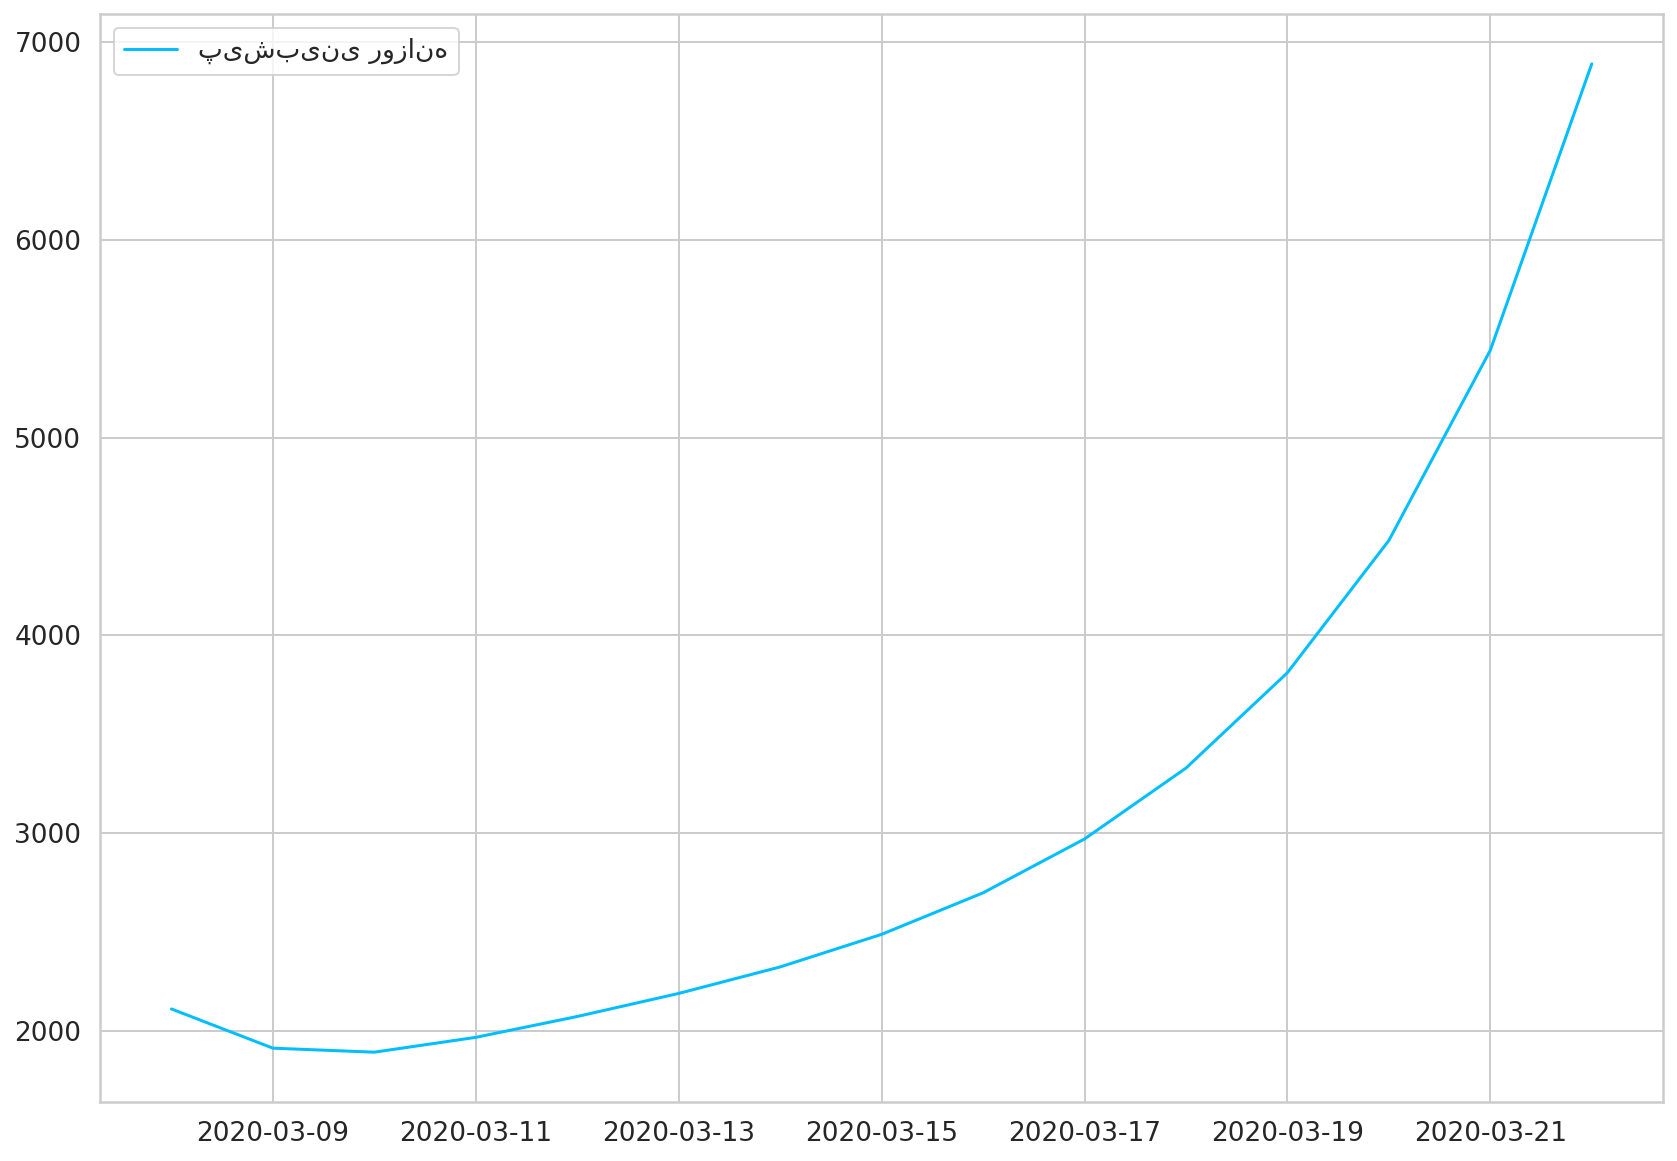

In [157]:
plt.plot(predicted_cases, label='پیشبینی روزانه')
plt.legend();

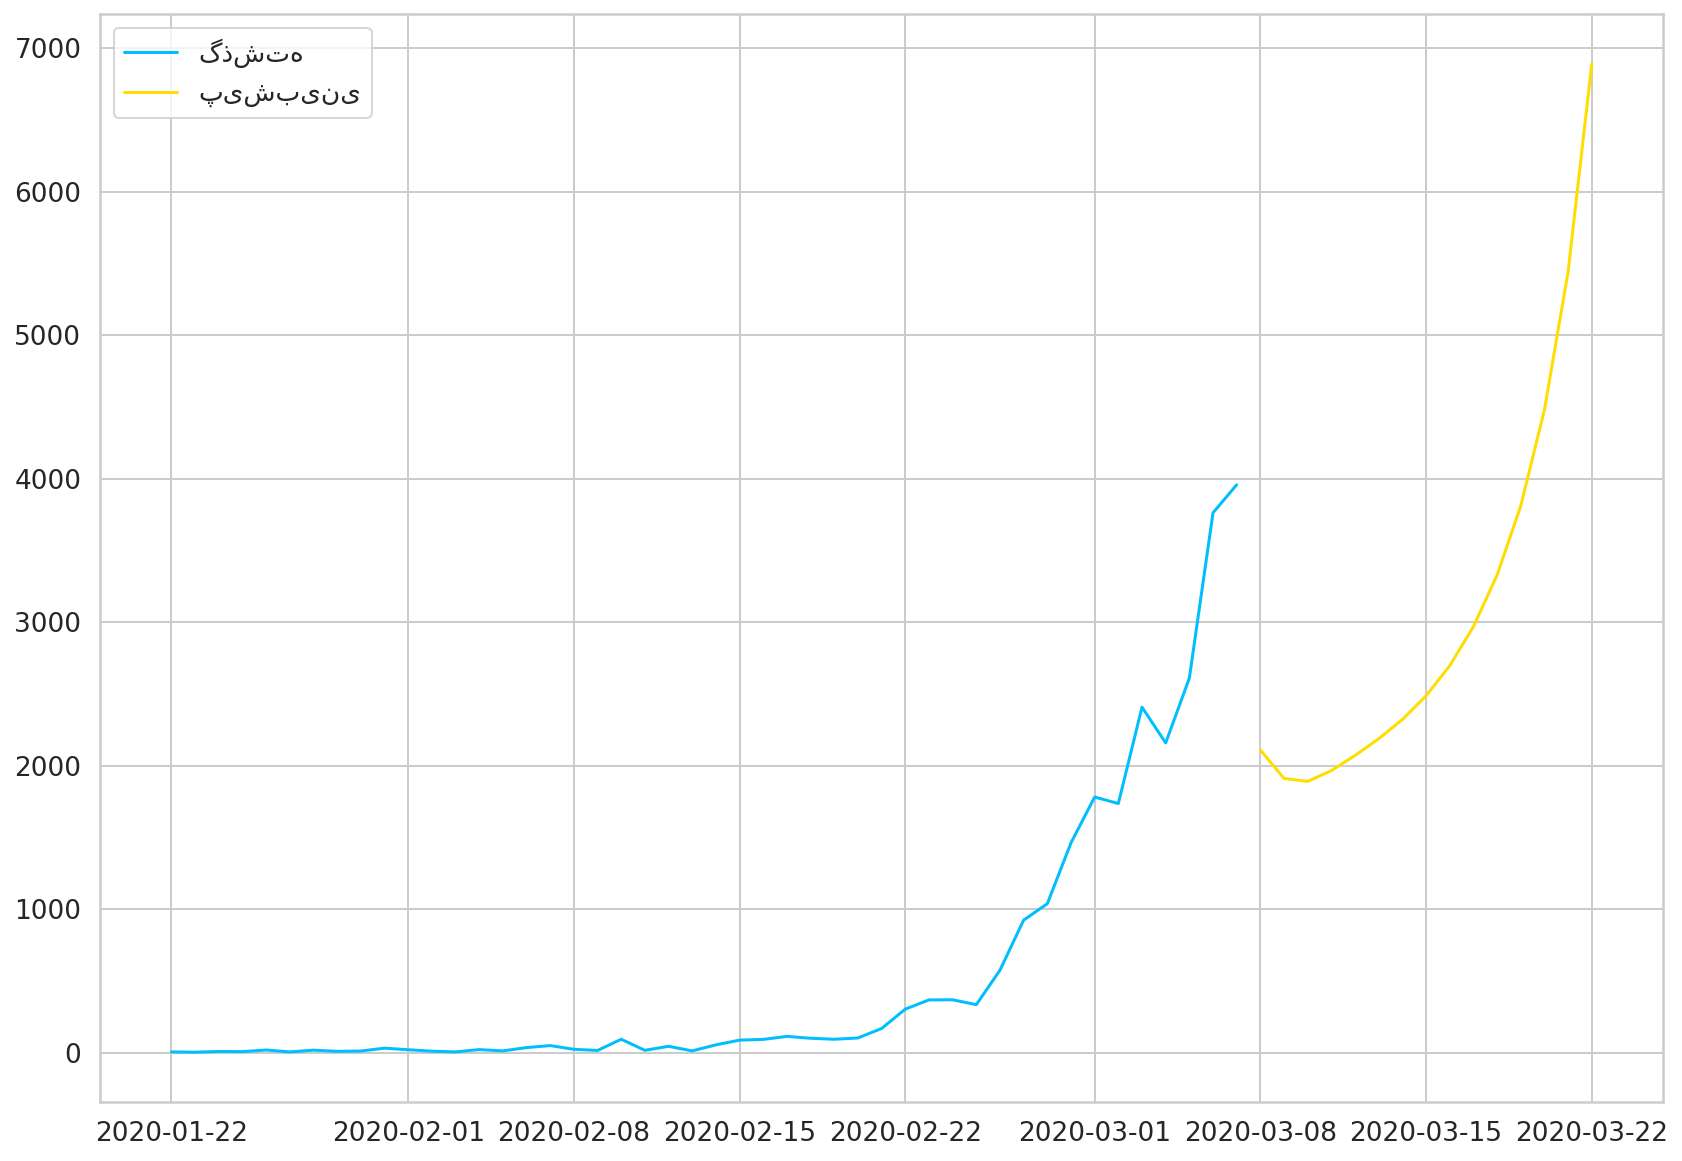

In [158]:
plt.plot(daily_cases_world, label='گذشته')
plt.plot(predicted_cases, label='پیشبینی')
plt.legend();